In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df_base = pd.read_csv("Risk_Analysis.csv")
df_base.head()

,ConditionsSky,NumberStruckActual,WildlifeSize,AlertScore,Risk
0,No Cloud,859,Medium,1729,High
1,Some Cloud,424,Small,429,High
2,No Cloud,261,Small,263,High
3,Some Cloud,806,Small,811,High
4,No Cloud,942,Small,944,High


### EDA

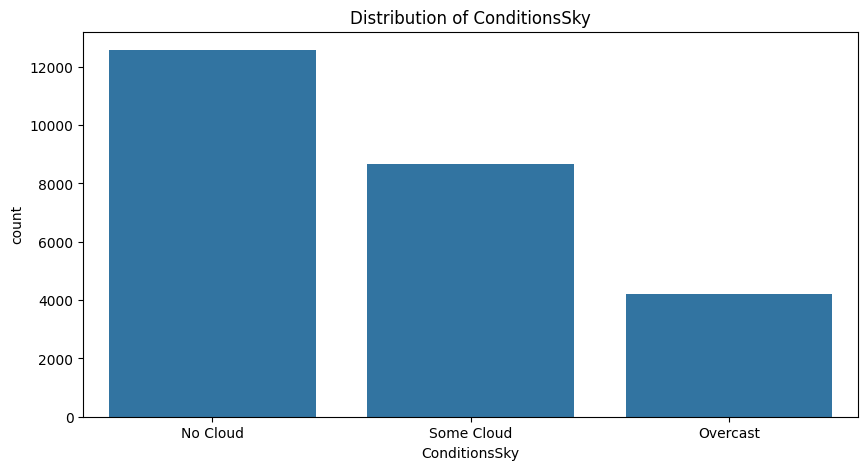

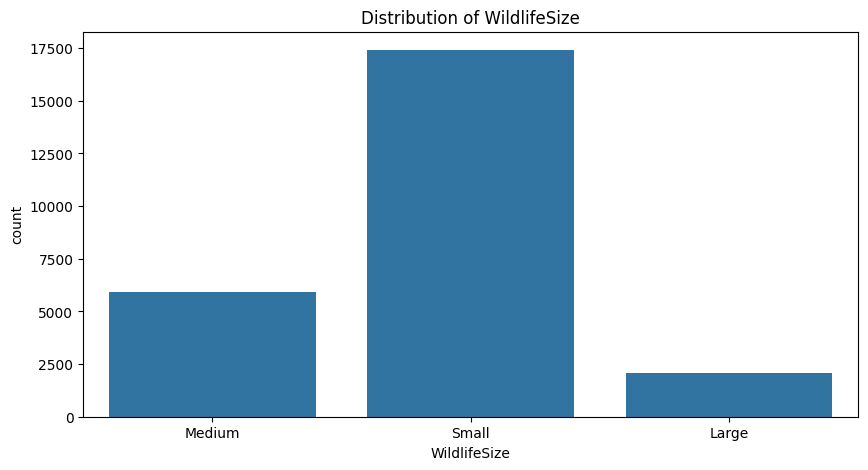

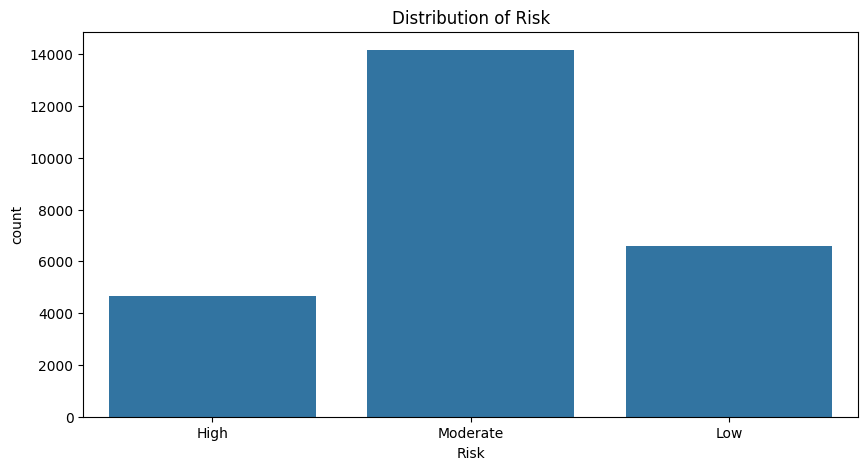

In [21]:
categorical_columns = ['ConditionsSky', 'WildlifeSize', 'Risk']

for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df_base, x=column)
    plt.title(f'Distribution of {column}')
    plt.show()

In [22]:
df_base.drop("AlertScore", axis=1, inplace=True)

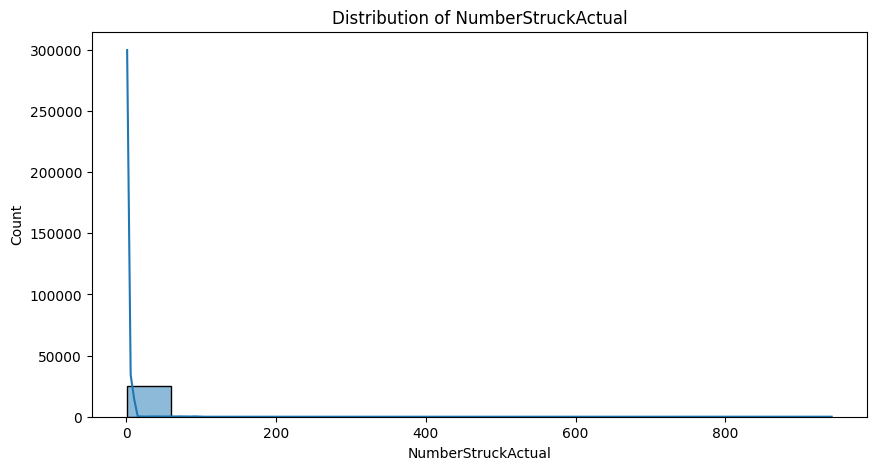

In [23]:
# plot the numerical numbers            
numerical_columns = ['NumberStruckActual']

for column in numerical_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_base, x=column, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()



In [24]:
from sklearn.preprocessing import OneHotEncoder

# Ordinal encoding for WildlifeSize and Risk
ordinal_mapping = {
    'WildlifeSize': {'Small': 0, 'Medium': 1, 'Large': 2},
    'Risk': {'Low': 0, 'Moderate': 1, 'High': 2}
}

df_ordinal = df_base.copy()
for column, mapping in ordinal_mapping.items():
    df_ordinal[column] = df_ordinal[column].map(mapping)

# One-hot encoding for ConditionsSky
one_hot_encoder = OneHotEncoder(sparse_output=False)
conditions_sky_encoded = one_hot_encoder.fit_transform(df_ordinal[['ConditionsSky']])
conditions_sky_encoded_df = pd.DataFrame(conditions_sky_encoded, columns=one_hot_encoder.get_feature_names_out(['ConditionsSky']))

# Combine the encoded columns with the rest of the dataframe
df_encoded = pd.concat([df_ordinal.drop('ConditionsSky', axis=1), conditions_sky_encoded_df], axis=1)

df_encoded.head()

,NumberStruckActual,WildlifeSize,Risk,ConditionsSky_No Cloud,ConditionsSky_Overcast,ConditionsSky_Some Cloud
0,859,1,2,1.0,0.0,0.0
1,424,0,2,0.0,0.0,1.0
2,261,0,2,1.0,0.0,0.0
3,806,0,2,0.0,0.0,1.0
4,942,0,2,1.0,0.0,0.0


In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras import Input

# Define the features (X) and target variable (y)
X = df_encoded.drop(columns=['Risk']) 
y = df_encoded['Risk']

#Ensure the target variable (y) is integer-encoded and then one-hot encode it
y = y.fillna(y.mode()[0])  # Fill missing values with the most frequent value
y_integer_encoded = y.astype(int)  # Ensure y is integer-encoded
y_encoded = to_categorical(y_integer_encoded, num_classes=3)  # 3 classes: 0 (Low), 1 (Moderate), 2 (High)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 4: Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [26]:
print("Class distribution in training data:", np.bincount(np.argmax(y_train, axis=1)))
print("Class distribution in test data:", np.bincount(np.argmax(y_test, axis=1)))

Class distribution in training data: [ 5300 11338  3705]
Class distribution in test data: [1304 2822  960]


In [27]:


# Build the Neural Network
NN_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define the input shape
    Dense(64, activation='relu'),      # First hidden layer
    Dense(32, activation='relu'),      # Second hidden layer
    Dense(16, activation='relu'),      # Third hidden layer
    Dense(3, activation='softmax')     # Output layer (3 classes)
])


# Compile the model
NN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
NN_history = NN_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = NN_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")




Epoch 1/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7363 - loss: 0.6851 - val_accuracy: 0.9236 - val_loss: 0.2386
Epoch 2/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9299 - loss: 0.2235 - val_accuracy: 0.9359 - val_loss: 0.2220
Epoch 3/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9315 - loss: 0.2177 - val_accuracy: 0.9339 - val_loss: 0.2149
Epoch 4/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9343 - loss: 0.2149 - val_accuracy: 0.9309 - val_loss: 0.2077
Epoch 5/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9369 - loss: 0.2059 - val_accuracy: 0.9366 - val_loss: 0.1973
Epoch 6/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.2065 - val_accuracy: 0.9341 - val_loss: 0.2018
Epoch 7/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9333 - loss: 0.2099 - val_accuracy: 0.9395 - val_loss: 0.1971
Epoch 8/50
509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9370 - loss: 0.2033 - val_accuracy: 0.

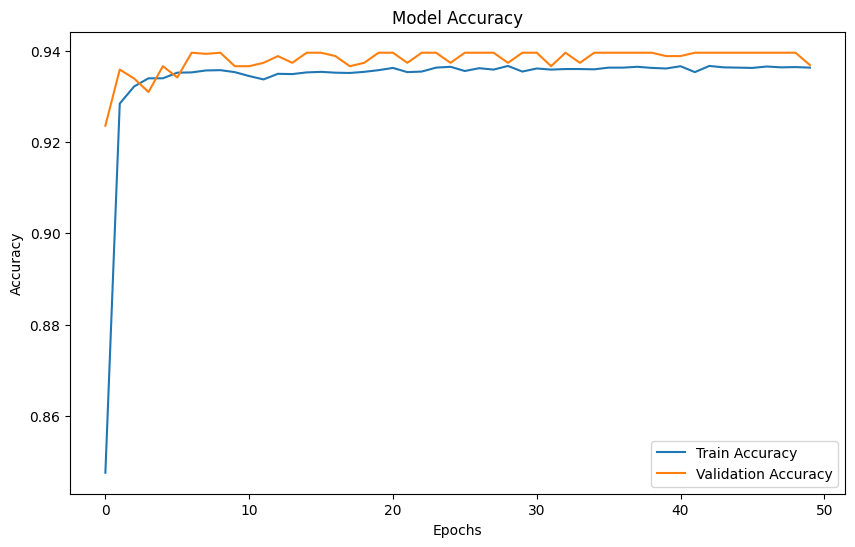

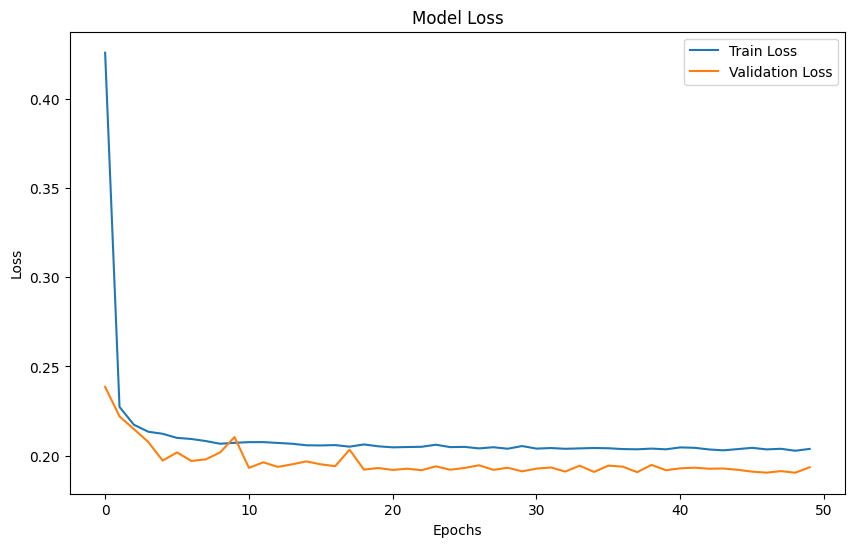

In [28]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(NN_history.history['accuracy'], label='Train Accuracy')
plt.plot(NN_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(NN_history.history['loss'], label='Train Loss')
plt.plot(NN_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

         Low       0.94      1.00      0.97      1304
    Moderate       0.92      0.97      0.94      2822
        High       0.98      0.74      0.84       960

    accuracy                           0.93      5086
   macro avg       0.95      0.90      0.92      5086
weighted avg       0.94      0.93      0.93      5086

Confusion Matrix:
[[1304    0    0]
 [  67 2737   18]
 [  10  244  706]]


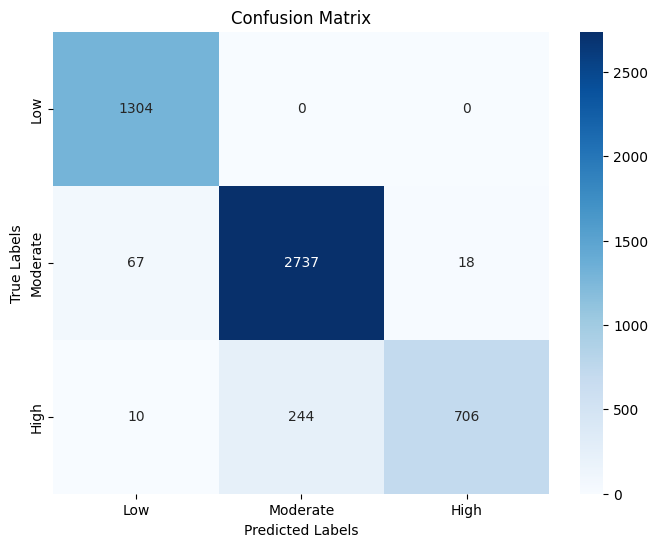

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Step 8: Evaluate the model and make predictions
y_pred = NN_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Generate classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['Low', 'Moderate', 'High'], labels=[0, 1, 2]))

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Moderate', 'High'], yticklabels=['Low', 'Moderate', 'High'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [41]:
from sklearn.model_selection import KFold
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Input

# Number of splits for KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Variables to store cross-validation results
cv_loss = []
cv_accuracy = []

# Perform KFold cross-validation
for train_index, val_index in kf.split(X_train):
    X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    
    # Build the Neural Network model
    NN_model = Sequential([
        Input(shape=(X_train_cv.shape[1],)),  # Define the input shape
        Dense(64, activation='relu'),         # First hidden layer
        Dense(32, activation='relu'),         # Second hidden layer
        Dense(16, activation='relu'),         # Third hidden layer
        Dense(3, activation='softmax')        # Output layer (3 classes)
    ])

    # Compile the model
    NN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    NN_model.fit(X_train_cv, y_train_cv, epochs=50, batch_size=32, validation_data=(X_val_cv, y_val_cv), verbose=0)
    
    # Evaluate the model on validation data
    val_loss, val_accuracy = NN_model.evaluate(X_val_cv, y_val_cv, verbose=0)
    cv_loss.append(val_loss)
    cv_accuracy.append(val_accuracy)

# Calculate the mean and standard deviation of cross-validation results
mean_cv_loss = np.mean(cv_loss)
mean_cv_accuracy = np.mean(cv_accuracy)
std_cv_loss = np.std(cv_loss)
std_cv_accuracy = np.std(cv_accuracy)

print(f"Cross-validation Loss: {mean_cv_loss:.4f} ± {std_cv_loss:.4f}")
print(f"Cross-validation Accuracy: {mean_cv_accuracy:.4f} ± {std_cv_accuracy:.4f}")


Cross-validation Loss: 0.2014 ± 0.0079
Cross-validation Accuracy: 0.9365 ± 0.0021


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [31]:
# Initialize the Random Forest model
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust `n_estimators` as needed

# Train the Random Forest model
RF_model.fit(X_train, y_train)

# Predict on test data
y_pred = RF_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9365


Classification Report:
              precision    recall  f1-score   support

         Low       0.94      1.00      0.97      1304
    Moderate       0.92      0.98      0.95      2822
        High       1.00      0.74      0.85       960

    accuracy                           0.94      5086
   macro avg       0.95      0.90      0.92      5086
weighted avg       0.94      0.94      0.93      5086

Confusion Matrix:
[[1304    0    0]
 [  67 2753    2]
 [  10  244  706]]


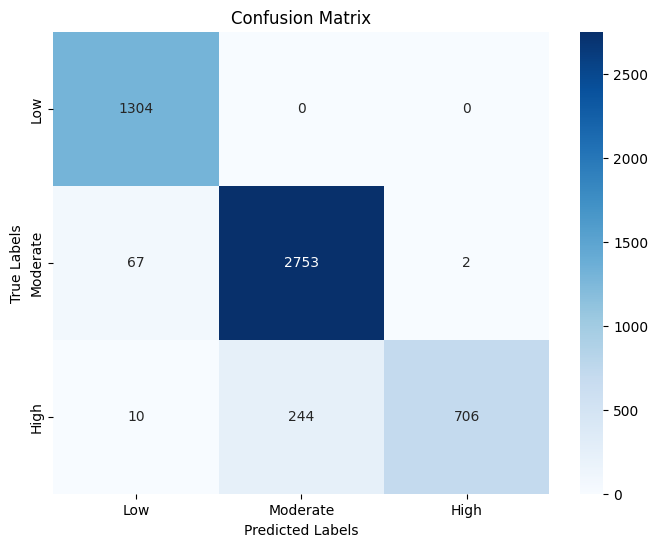

In [33]:
# Convert one-hot encoded labels to class labels
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['Low', 'Moderate', 'High']))

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Moderate', 'High'], yticklabels=['Low', 'Moderate', 'High'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Initialize the Random Forest model
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation (5-fold by default)
cv_scores = cross_val_score(RF_model, X_train, y_train, cv=5, scoring='accuracy')

# Calculate the mean and standard deviation of cross-validation results
mean_cv_accuracy = np.mean(cv_scores)
std_cv_accuracy = np.std(cv_scores)

print(f"Cross-validation Accuracy: {mean_cv_accuracy:.4f} ± {std_cv_accuracy:.4f}")


Cross-validation Accuracy: 0.9370 ± 0.0040
